In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

# Vineyard functions
from VineyardFinal import *

# Matrix Operations
import numpy as np
import pandas as pd
from scipy import stats

# Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

# Interactive Plots
import plotly.express as px
import plotly.graph_objects as go

# Geospatial and graphs
import geopandas as gpd
from gerrychain import Graph
import networkx as nx

# My Dependencies
import warnings
warnings.filterwarnings('ignore', message='Found islands', category=UserWarning) # Getting rid of pesky degree-0 graph warnings 


pd.options.mode.chained_assignment = None
plt.rcParams['text.usetex'] = False

INFINITY = 1e6
n = 100


# VERSIONS USED
# !pip install gerrychain==0.2.22
# !pip install shapely==2.0.2
# !pip install geopandas==0.12.2
#################

custom_rc = {
    # font general
    'font.family': 'Times New Roman',

    # ticks
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.labelsize': 14,


    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.labelsize': 12,


    # title
    'axes.titlesize': 18,
    'axes.titleweight': 'bold', 
    'axes.titlecolor': 'black', 

    # axes
    'axes.labelsize': 16,
    'axes.labelweight': 'normal',  
    'axes.labelcolor': 'black',      

    # legend
    'legend.fontsize': 14,  
}

mpl.rcParams.update(custom_rc)


## Plotting Function

In [2]:
def map_and_pd(graph, PD, tractshapes, h, npoints=5, verbose=False, popthreshold=10, reorder=None, c = 'RdBu', mx = 1, vals_to_flag = None, ax = None, mapax = None):
    '''
    graph: a nx graph generated using "graph.from_gdf" 
    PD: the persistence diagram generated using values from the graph's nodes
    gdf: the gdf you wish to plot (will plot column named 'Homotopy')
    npoints: the number of points to color and match, counting from the most persistent
    '''

    if ax is None or mapax is None:
        fig, (ax, mapax) = plt.subplots(1,2, figsize=(8,12), gridspec_kw={'width_ratios': [1,1]})


    

    # plotting PD
    cmap = plt.get_cmap('tab20')
    if reorder==None:
        reorder=range(npoints)
    colors = [cmap(reorder[x]/(7-1)) for x in range(npoints)]

    PD = sorted(PD, key = lambda x: x[1]-x[0], reverse=True)
    ax.scatter(
        [x[0] for x in (PD)[:]],
        [x[1] for x in (PD)[:]],
        color='black',
        s=10
    )


    # determining what values we flag. 
    # if no argument is made, we flag the top npoints many persistent points
    # if an argument is passed, we flag points who's filtration value (1-{birth value}) match 
    # plotting top persistence if None
    if vals_to_flag == None:
        vals_to_flag = []
        try:
            for i in range(npoints):
                vals_to_flag.append(1 - PD[i][0])
                ax.scatter(
                    [x[0] for x in (PD)[i:i+1]],
                    [x[1] for x in (PD)[i:i+1]],
                    color=colors[i],
                    s=40
                )  
        except IndexError:
            # if npoints is too high. plot most persistent point only
            vals_to_flag.append(1 - PD[0][0])
            ax.scatter(
                [x[0] for x in (PD)[0:1]],
                [x[1] for x in (PD)[0:1]],
                color=colors[0],
                s=40
            )              

    # plotting custom flagged values
    else:
        for i, v in enumerate(vals_to_flag):
            points = [
                p for p in PD if np.abs(
                    1-p[0] - v
                ) <= 1e-6
            ]
            if len(points) != 0:
                ax.scatter(
                points[0][0],
                points[0][1],
                color=colors[i],
                s=40
            )  
    ax.set_xlim(0,1)
    ax.set_xticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_ylim(0,1.1)
    ax.set_aspect(1)
    ax.plot([0,1], [0,1], linestyle='dashed', c='grey')
    ax.annotate('$\infty$', (-0,1))
    
    
    
    #map
    for i, n in enumerate(graph.nodes):
        graph.nodes[n]['Homotopy'] = h[i]

    GEOIDs = [graph.nodes[n]["GEOIDGIS"] for n in graph.nodes]
    cityshapes = tractshapes[tractshapes.GEOID.isin(GEOIDs)]
    cityshapes = cityshapes.set_index('GEOID')
    for n in graph.nodes:
        cityshapes.loc[graph.nodes[n]['GEOIDGIS'], 'perc'] = graph.nodes[n]['Homotopy'] 
    cityshapes['dummy'] = [1]*len(cityshapes)
    wholecity = cityshapes.dissolve(by='dummy')


    coloring = c
    
    cityshapes.plot(
        column='perc',
        cmap=coloring,
        vmin=0, vmax=1,
        ax=mapax,
        legend=True,
        legend_kwds={'shrink': 0.3}
    )
    wholecity.boundary.plot(
        edgecolor='black',
        ax=mapax,
        linewidth=0.2
    )

    mapax.axis('off')

    # highlighting flagged values
    for i, val in enumerate(vals_to_flag):
        nodes = [
            n for n in graph.nodes if np.abs(
                (graph.nodes[n]['Homotopy']) - val
            ) <= 1e-7 and graph.nodes[n]['TOTPOP'] > popthreshold
        ]

        try:

            node = nodes[0]
            if verbose:
                print(graph.nodes[node], '\n')
            x,y = graph.nodes[node]['C_X'], graph.nodes[node]['C_Y']
            extent = mapax.get_ylim()[1]-mapax.get_ylim()[0]
            patch = plt.Circle((x, y), extent*0.025, color=colors[i], fill=False, linewidth=2)
            mapax.add_patch(patch)
        except IndexError:
            pass
    return ax, mapax

def set_subgrid_title(fig, ax, mapax, title):
    ''' 
    Plot a centered title for a subgrid inside of a gridspec figure.
    '''

    bbox_pd = ax.get_position()
    bbox_map = mapax.get_position()

    center_x = (bbox_pd.x0 + bbox_map.x1) / 2
    top_y = max(bbox_pd.y1, bbox_map.y1)  

    # Add centered text
    fig.text(center_x, top_y - 0.035, title, ha='center', fontsize=12)

<>:76: DeprecationWarning: invalid escape sequence '\i'


## Data

In [3]:
# census tractshapes
tractshapes = gpd.read_file(
            '../dataIn/cities/nhgis0010_shape/nhgis0010_shapefile_tl2020_us_tract_2020/US_tract_2020.shp'
        )
# results from `../cities/cities.ipynb`
results_df = pd.read_csv("../dataOut/city_metrics.csv", index_col = "Name")

## Directories

In [4]:
outDir = "../figs/cities"
os.makedirs(outDir, exist_ok= True)

## Milwaukee, WI / Lexington, KY 4 Square

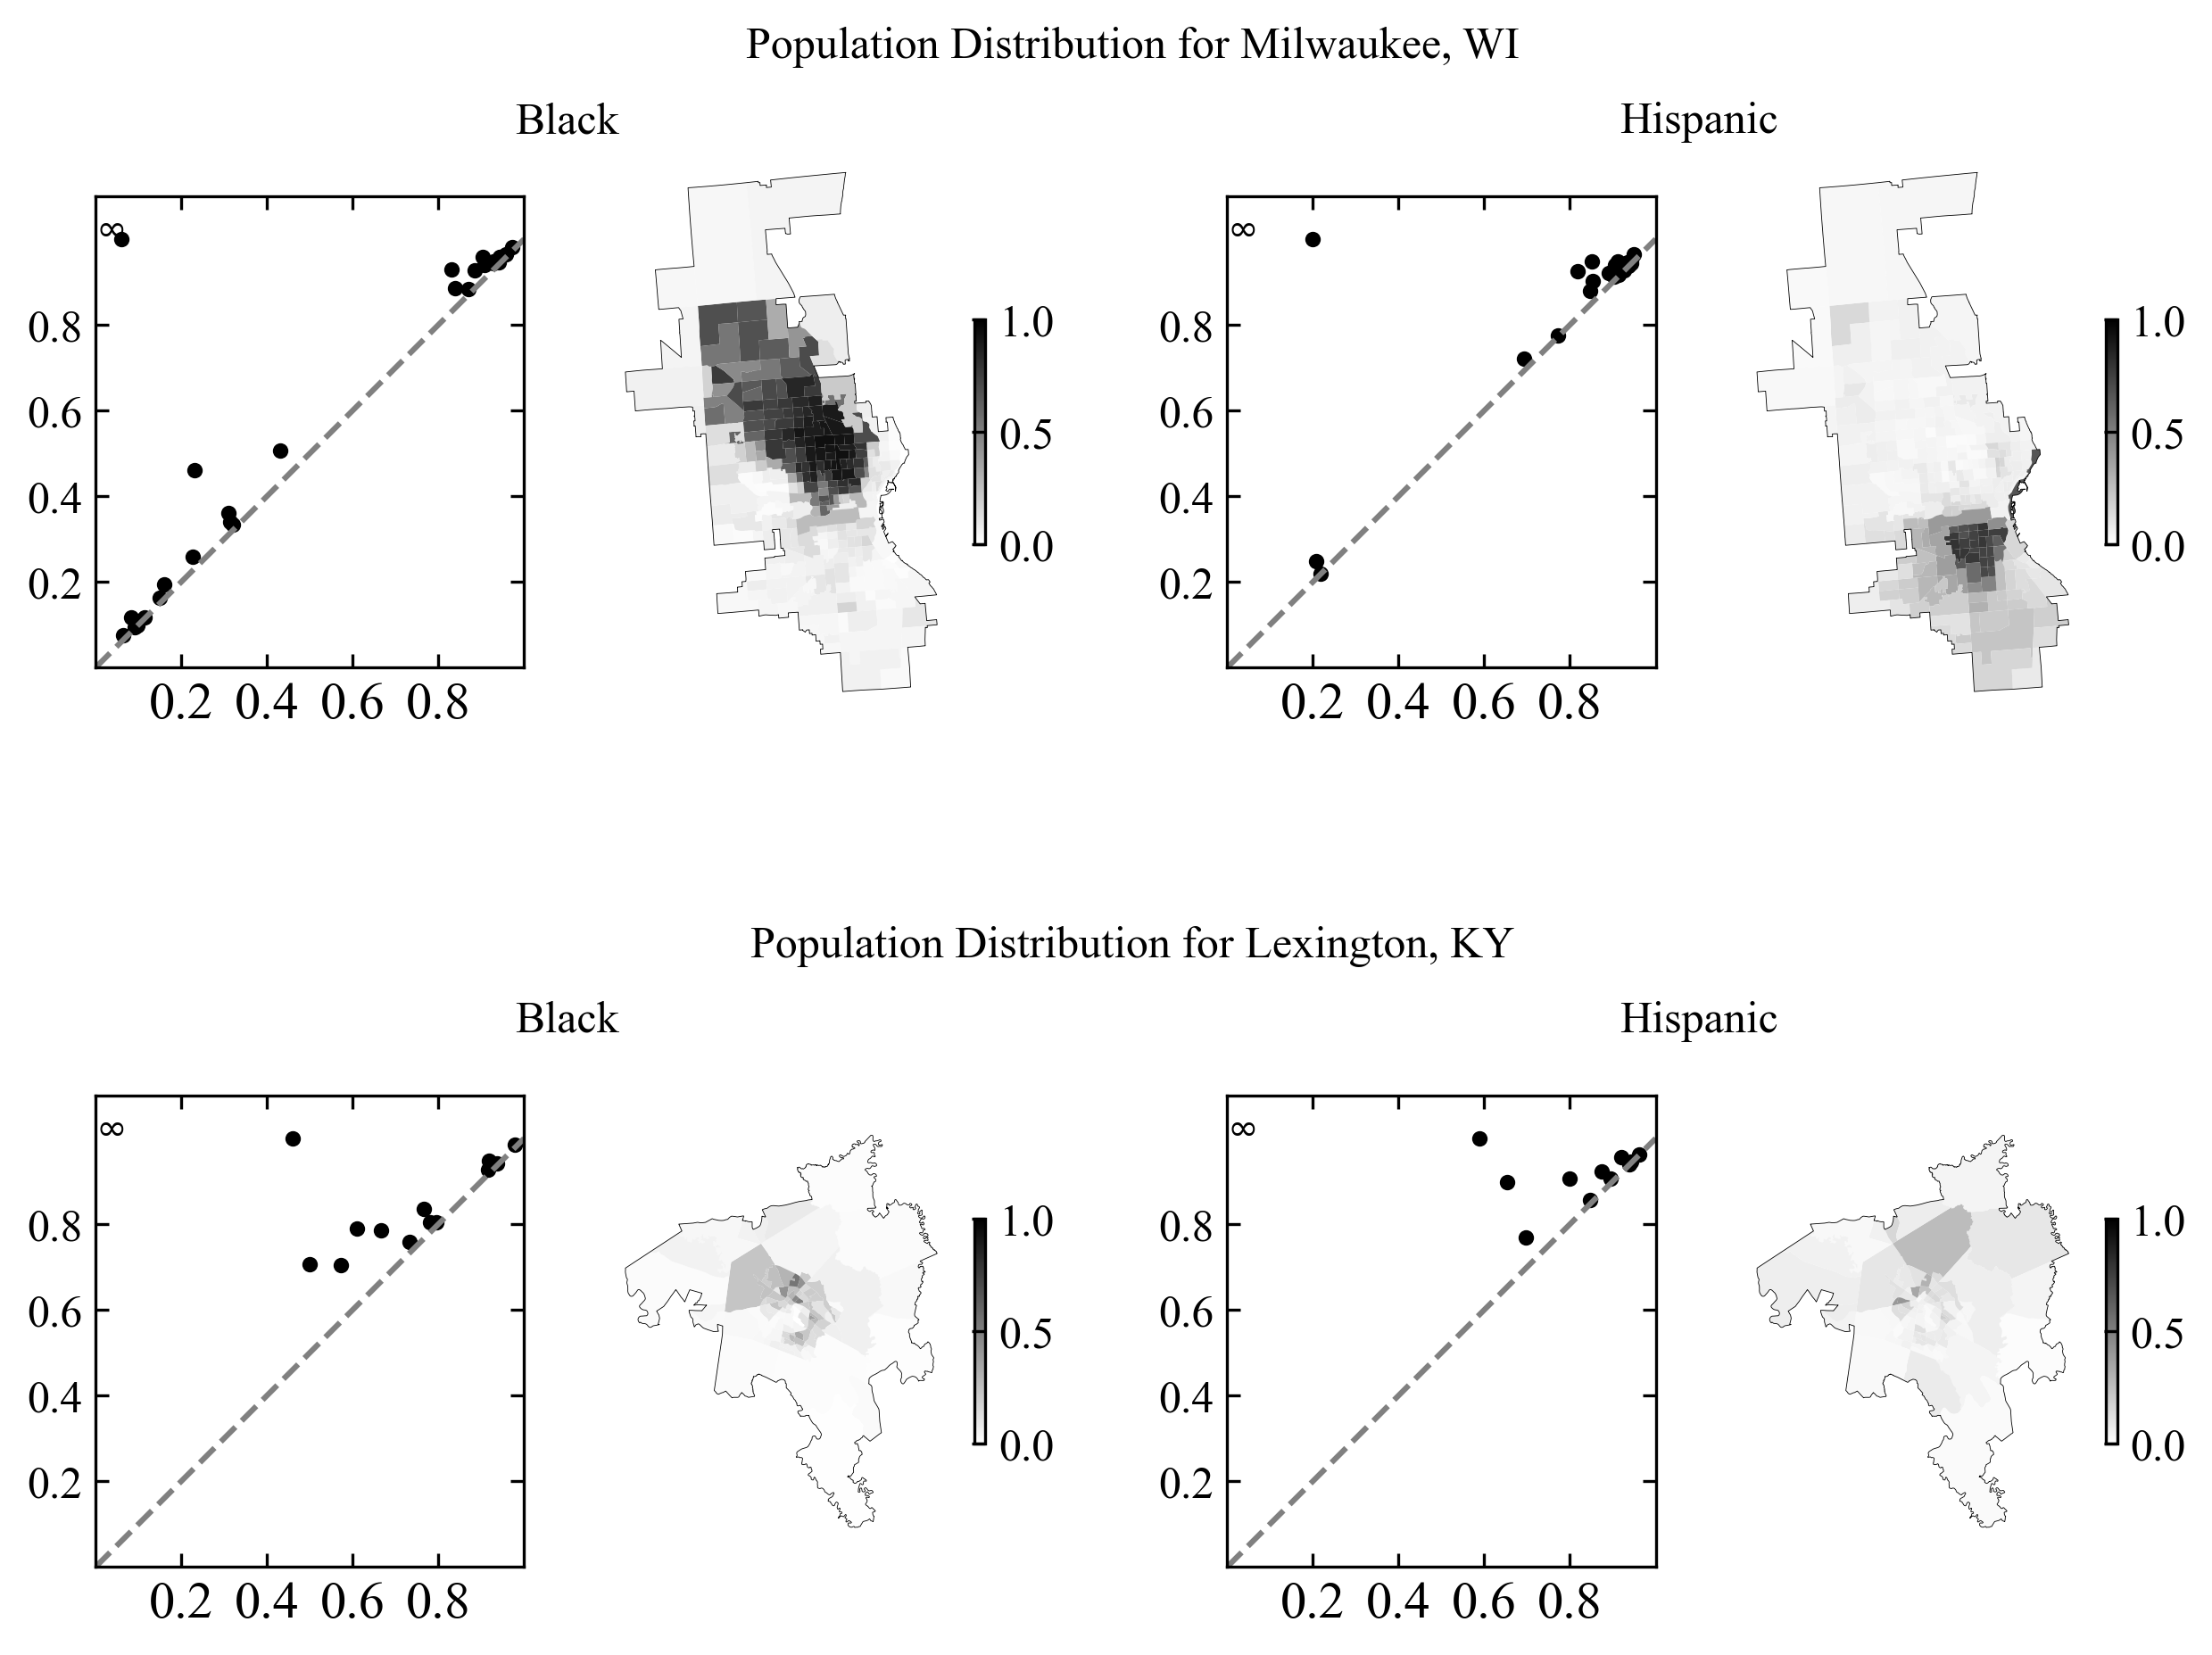

In [5]:
# Cities Plotted
list_of_cities = ['MilwaukeeWI', "LexingtonKY"]
city_titles = ['Population Distribution for Milwaukee, WI', 'Population Distribution for Lexington, KY']

# f, g, and length of homotopy
col1 = 'BLACK'
col2 = 'HISP'
t = 100 


# Init Fig
fig = plt.figure(figsize=(10, 8), dpi=300)
outer_grid = gridspec.GridSpec(2, 2, figure=fig)

custom_cmap = 'binary'

titles = ["Black", "Hispanic"]

for n, city in enumerate(list_of_cities):

    # Get dual graph
    G = Graph.from_json('../dataIn/cities/cities2020data/{}.json'.format(city))
        
    # Calculate homotopy
    f = np.array(list((nx.get_node_attributes(G,col1).values()))) / np.array(list((nx.get_node_attributes(G,'TOTPOP').values()))) 
    g = np.array(list((nx.get_node_attributes(G,col2).values()))) / np.array(list((nx.get_node_attributes(G,'TOTPOP').values()))) 

    f = np.nan_to_num(f, 0)
    g = np.nan_to_num(g, 0)

    
    Hs = Homotopy(f,g,t)   
    # Generate PDS
    PD0 = []
    for h in Hs:
        for j, v in enumerate(G.nodes()):
            G.nodes[v]['Homotopy'] = h[j]
        PD0.append(Get_Adjacency_Persistence(G,'Homotopy', dimension = 0))

    # Plot BLACK and HISP
    for i in range(2):
        inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[n, i], width_ratios=[1, 1])

        # Create two subplots inside that one quadrant
        ax_pd = fig.add_subplot(inner_grid[0])
        ax_map = fig.add_subplot(inner_grid[1])

        # Set title
        set_subgrid_title(fig, ax_pd, ax_map, titles[i])

        
        # Plot pd and chloropleth
        map_and_pd(G, PD0[-i], tractshapes, h=Hs[-i], npoints=0, c=custom_cmap, mx=1,
                vals_to_flag=None, ax=ax_pd, mapax=ax_map)
    
    row_pos = outer_grid[n, :].get_position(fig)
    row_center = (row_pos.x0 + row_pos.x1) / 2
    row_top = row_pos.y1

    fig.text(row_center, row_top , f"{city_titles[n]}", ha='center', fontsize=12)
    

plt.savefig(os.path.join(outDir, "MilwaukeeWI_LexingtonKY_4x4_noColor_P.png"), dpi=600, bbox_inches='tight', pad_inches=0.1)

## Dallas, TX / Phoenix, AZ 4 Square

/var/folders/_b/bl5yw1q15msg5ky9z_04dpt40000gn/T/ipykernel_98341/283955178.py:25: RuntimeWarning: invalid value encountered in divide
  f = np.array(list((nx.get_node_attributes(G,col1).values()))) / np.array(list((nx.get_node_attributes(G,'TOTPOP').values())))


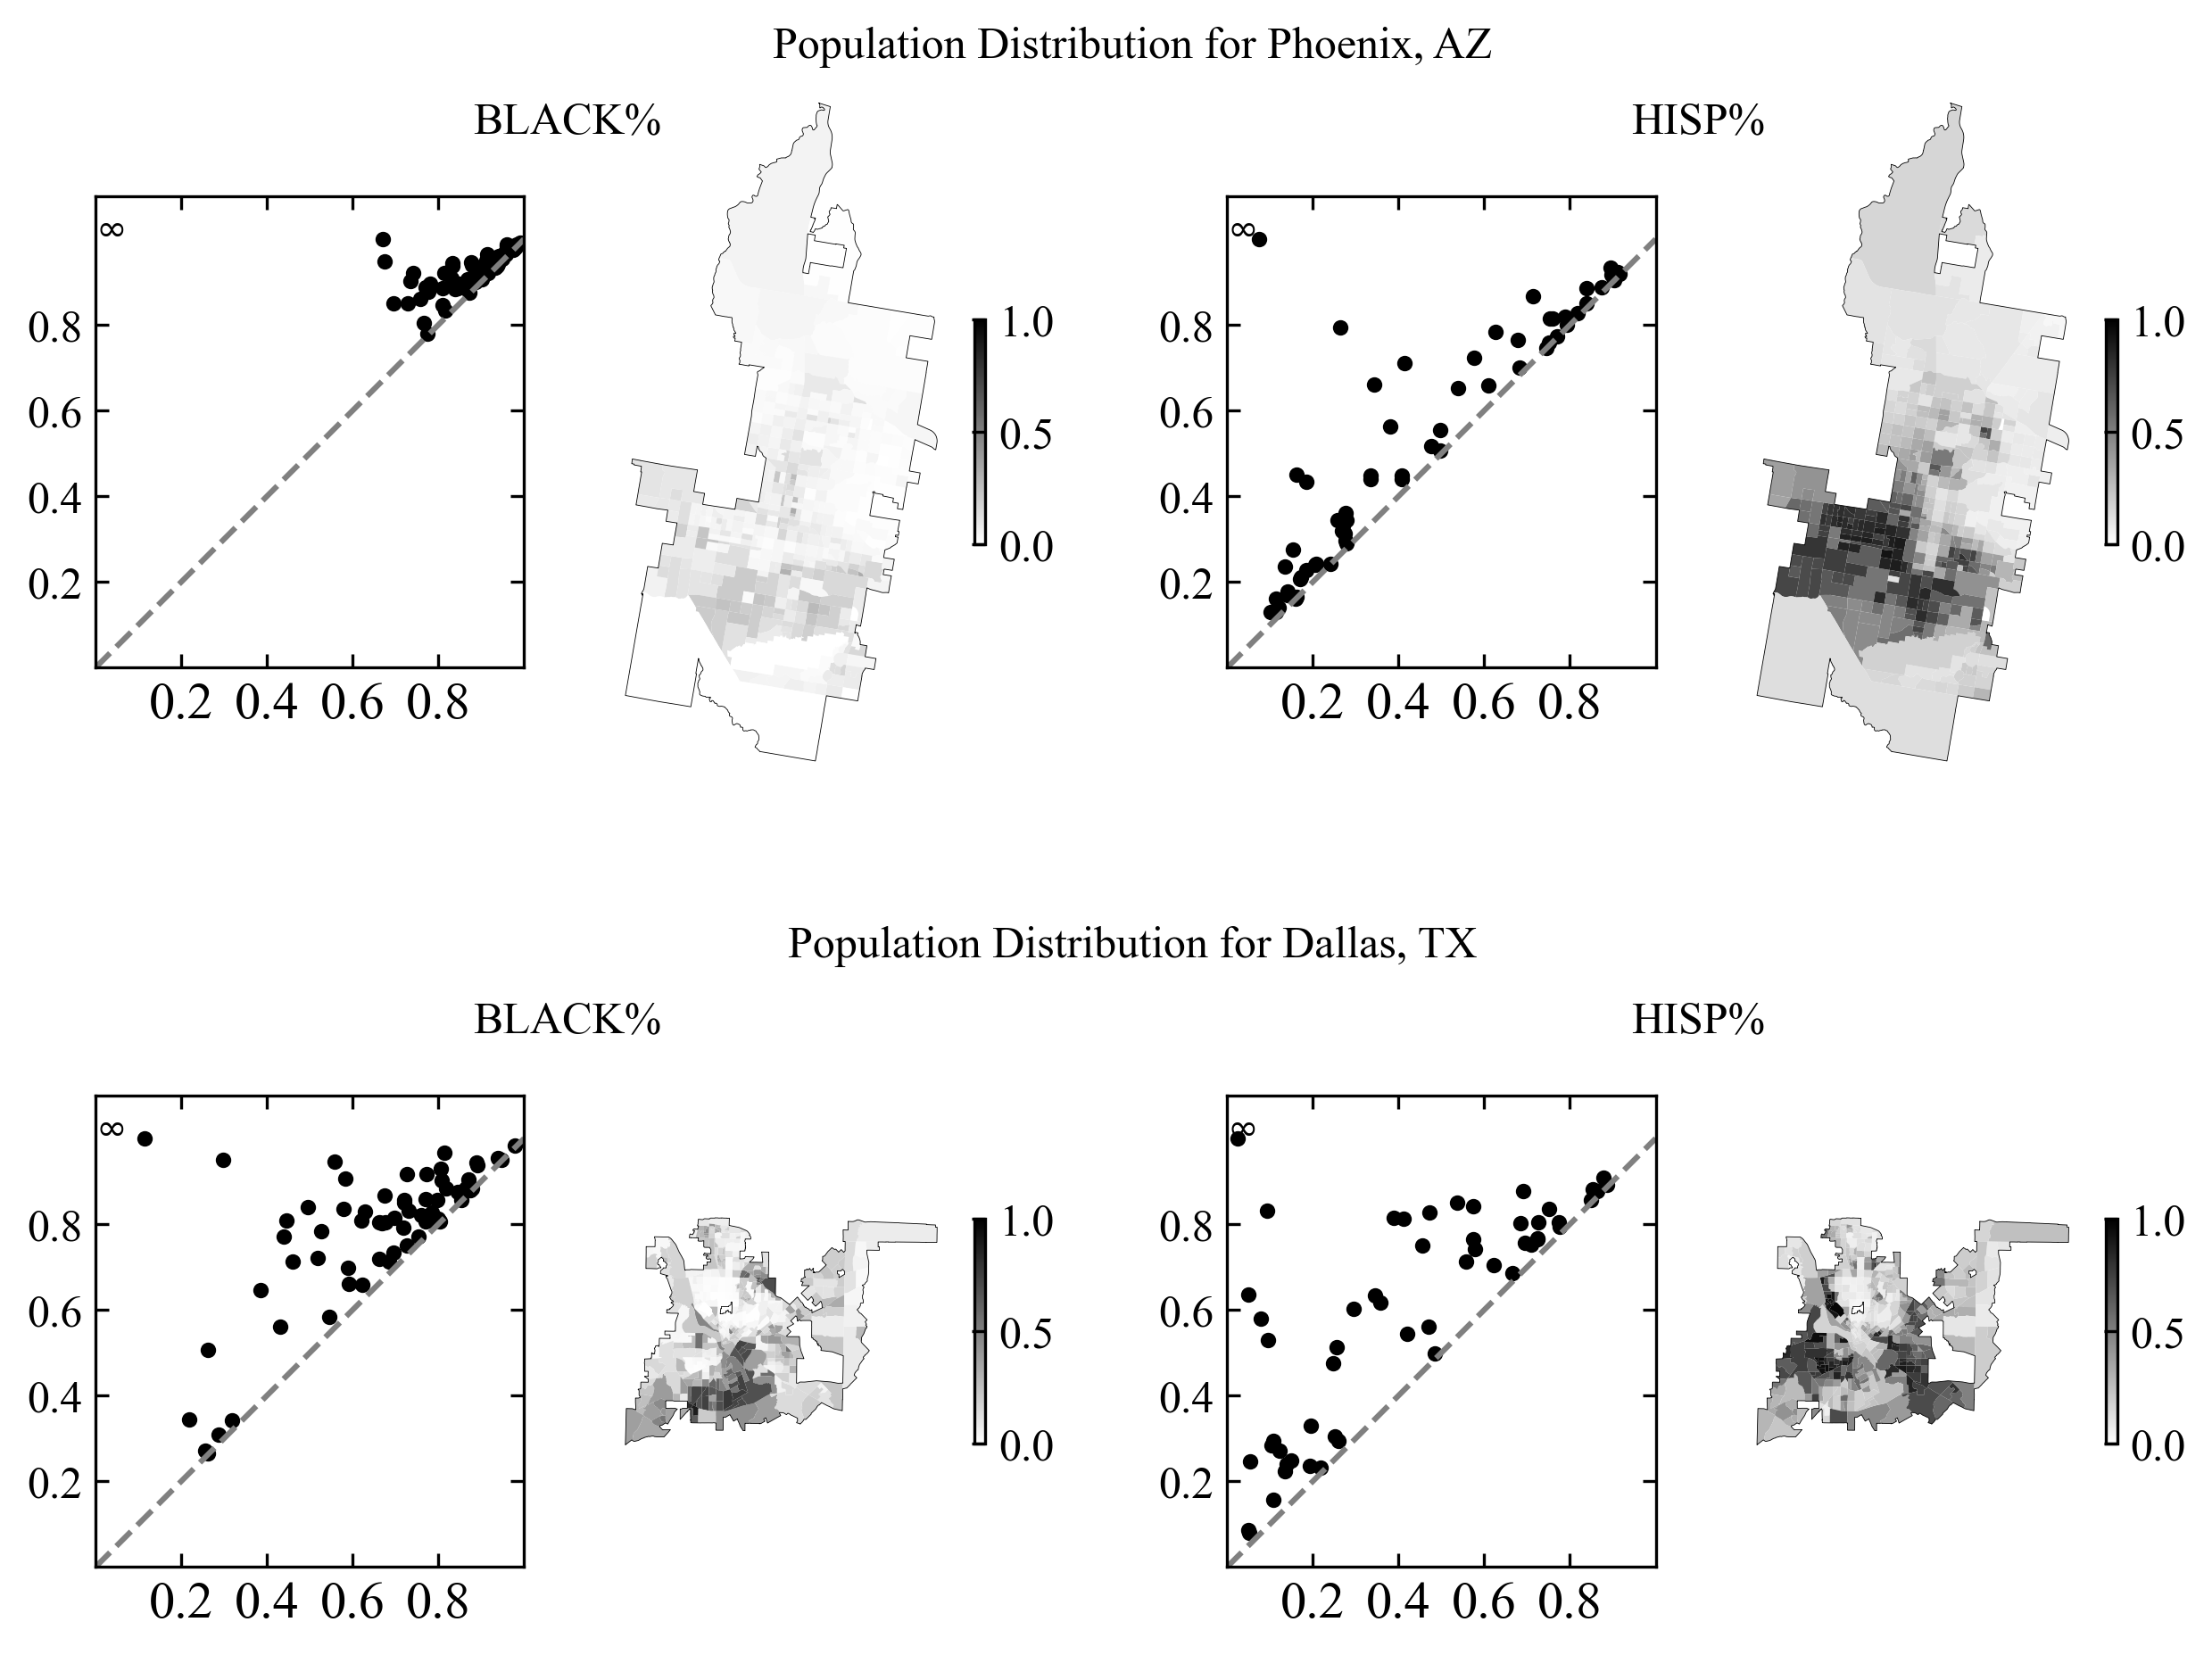

In [6]:
# Cities Plotted
list_of_cities = ['PhoenixAZ', "DallasTX"]
city_titles = ['Population Distribution for Phoenix, AZ', 'Population Distribution for Dallas, TX']

# f, g, and length of homotopy
col1 = 'BLACK'
col2 = 'HISP'
t = 100 


# Init Fig
fig = plt.figure(figsize=(10, 8), dpi=300)
outer_grid = gridspec.GridSpec(2, 2, figure=fig)

custom_cmap = 'binary'

titles = ["BLACK%", "HISP%"]

for n, city in enumerate(list_of_cities):

    # Get dual graph
    G = Graph.from_json('../dataIn/cities/cities2020data/{}.json'.format(city))
    
    # Calculate homotopy
    f = np.array(list((nx.get_node_attributes(G,col1).values()))) / np.array(list((nx.get_node_attributes(G,'TOTPOP').values()))) 
    g = np.array(list((nx.get_node_attributes(G,col2).values()))) / np.array(list((nx.get_node_attributes(G,'TOTPOP').values()))) 

    f = np.nan_to_num(f, 0)
    g = np.nan_to_num(g, 0)

    
    Hs = Homotopy(f,g,t)   
    # Generate PDS
    PDS = []
    for h in Hs:
        for j, v in enumerate(G.nodes()):
            G.nodes[v]['Homotopy'] = h[j]
        PDS.append(Get_Adjacency_Persistence(G,'Homotopy', dimension = 0))

    # Plot BLACK and HISP
    for i in range(2):
        inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[n, i], width_ratios=[1, 1])

        # Create two subplots inside that one quadrant
        ax_pd = fig.add_subplot(inner_grid[0])
        ax_map = fig.add_subplot(inner_grid[1])

        # Set title
        set_subgrid_title(fig, ax_pd, ax_map, titles[i])

        
        # Plot pd and chloropleth
        map_and_pd(G, PDS[-i], tractshapes, h=Hs[-i], npoints=0, c=custom_cmap, mx=1,
                vals_to_flag=None, ax=ax_pd, mapax=ax_map)
    
    row_pos = outer_grid[n, :].get_position(fig)
    row_center = (row_pos.x0 + row_pos.x1) / 2
    row_top = row_pos.y1

    fig.text(row_center, row_top , f"{city_titles[n]}", ha='center', fontsize=12)

plt.savefig(os.path.join(outDir, "PhoenixAZ_DallasTX_4x4_noColor_P.png"), dpi=600, bbox_inches='tight', pad_inches=0.1)

## V / W1 Scatterplot

In [7]:
results_df.describe()
query_str = "`BLACK%` > 30.0" and "`HISP%` > 30.0"
plot_df = results_df.query(query_str)
plot_df

,w,w1,v,mvc,v/mvc,l1,l1w,l2,l2w,linf,linfw,R,R^2,BLACK%,HISP%,TotPop
Name,,,,,,,,,,,,,,,,
Los AngelesCA,0.404750,7.968404,3.962156,1.171905,3.380952,470.681151,0.374448,16.401870,0.013048,0.971453,0.000773,-0.003075,0.000009,9.045145,44.828166,4522371.0
HoustonTX,0.260292,6.219023,3.644369,0.913788,3.988199,296.851443,0.312147,12.503576,0.013148,0.957780,0.001007,-0.218397,0.047697,20.511568,42.345007,3896372.0
PhoenixAZ,0.596111,3.724352,1.238931,0.516250,2.399867,132.324711,0.315811,8.238029,0.019661,0.905965,0.002162,0.279586,0.078169,7.521771,39.617323,1793208.0
San AntonioTX,0.448002,1.699795,0.703139,0.327465,2.147219,196.892138,0.548446,11.360014,0.031643,1.000000,0.002786,-0.285986,0.081788,7.933187,59.909075,1909699.0
San DiegoCA,0.485688,2.937890,1.037172,0.585728,1.770740,91.383939,0.239225,6.284499,0.016452,0.965718,0.002528,0.333247,0.111054,5.759385,30.436252,1648544.0
DallasTX,0.292568,3.843987,2.293228,0.734171,3.123560,121.885455,0.270857,8.035363,0.017856,0.975000,0.002167,-0.110268,0.012159,21.419853,39.172391,1783621.0
AustinTX,0.428556,2.119711,0.752234,0.351467,2.140271,67.214338,0.244416,5.075424,0.018456,0.792256,0.002881,0.384995,0.148221,7.278586,31.896870,1244445.0
Fort WorthTX,0.403186,2.558044,1.088506,0.607614,1.791445,61.294785,0.230432,5.287222,0.019877,0.937758,0.003525,-0.100425,0.010085,17.196198,32.933608,1253027.0
El PasoTX,0.486184,1.307272,0.717712,0.296064,2.424179,121.353500,0.772952,9.950130,0.063377,0.966418,0.006156,-0.727518,0.529282,3.785270,80.622746,737411.0


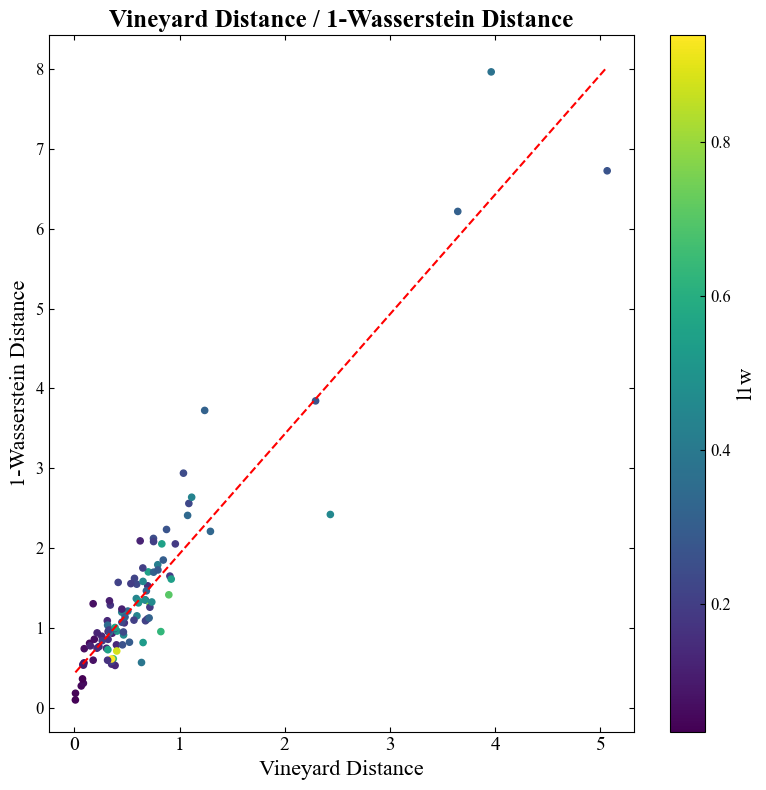

In [8]:
# Columns
col1 = "v" 
col2 = "w1"
colorKey = "l1w"


# Data
x,y = (results_df[f'{col1}'], results_df[f'{col2}'])
data = list(zip(x,y))

# Colorbar
z = results_df[f"{colorKey}"]

# Plot 
fig, ax = plt.subplots(1,1, figsize = (8,8))

## Scatter
sc = ax.scatter(x,y, c = z, alpha = 1, s= 20, cmap = 'viridis')

## Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
ax.plot(np.linspace(np.min(x),np.max(x),100), intercept + slope * np.linspace(np.min(x),np.max(x),100), 'r--',label='Fitted line')


# Plot settings
mx = results_df[[f'{col1}', f'{col2}']].values.max()
mn = results_df[[f'{col1}', f'{col2}']].values.min()

## axis labels

ax.set_title(f'Vineyard Distance / 1-Wasserstein Distance')
ax.set_xlabel('Vineyard Distance')
ax.set_ylabel('1-Wasserstein Distance')

cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(f"{colorKey}")

plt.tight_layout()

plt.savefig(os.path.join(outDir, f'{col1}_{col2}_scatterplot.png'), bbox_inches = 'tight')
